# A Diffusion Decision Model for Language-based Decisions

<img src="images/ddm_desc.jpeg" width="600">

Here, we use the `hddm` (Python) library$^1$ to model language-based decision making based on response-time & accuracy data from a binary forced-choice decision task. During each trial, subjects were presented with a digital image of an item (visual stimulus) and a verbal description (auditory stimulus). At the end of each trial, subjects were asked to indicate whether the two types of stimuli agreed (i.e. visual and auditory stimulus pointed to the same object) or were different (i.e. non-matching sound and image). Auditory and visual stimuli pairs fell under four distinct categories, as summarised below:  
- Condition 1 (**SS**): Same stimuli (see cat / hear cat)
- Condition 2 (**CP**): Phonologically congruent (see cat / hear hat)
- Condition 3 (**CS**): Semantically congruent (see cat / hear dog)
- Condition 4 (**US**): Unrelated stimuli (see house / hear cat)

In [30]:
# Environment setup
%matplotlib inline
%cd /lang_dec
# Imports
import warnings; warnings.filterwarnings('ignore')
import hddm
import numpy as np
import matplotlib.pyplot as plt
from utils import model_tools, signal_detection

/Users/celefthe/celefthe/projects/language_decision


In [199]:
# Import pilot models
pilot_data = hddm.load_csv('/lang_dec/data/pilot_clean.csv')
pilot_model = hddm.HDDM(pilot_data, depends_on={'v': 'stim'}, bias=True)
pilot_model.load_db(dbname='language_decision/models/pilot', db='txt')

pilot_model_threshold = hddm.HDDM(pilot_data, depends_on={'v': 'stim', 'a': 'stim'})
pilot_model_threshold.load_db(dbname='language_decision/models/pilot_threshold', db='txt')

In [29]:
# Import control models
controls_data = hddm.load_csv('/lang_dec/data/controls_clean.csv')
controls_model = hddm.HDDM(controls_data, depends_on={'v': 'stim'}, bias=True)
controls_model.load_db(dbname='language_decision/models/controls', db='txt')

controls_model_threshold = hddm.HDDM(controls_data, depends_on={'v': 'stim', 'a': 'stim'})
controls_model_threshold.load_db(dbname='language_decision/models/controls_threshold', db='txt')

In [28]:
# Import patient models
patients_data = hddm.load_csv('/lang_dec/data/patients_clean.csv')
patients_model = hddm.HDDM(patients_data, depends_on={'v': 'stim'}, bias=True)
patients_model.load_db(dbname='language_decision/models/patients', db='txt')

patients_model_threshold = hddm.HDDM(patients_data, depends_on={'v': 'stim', 'a': 'stim'})
patients_model_threshold.load_db(dbname='language_decision/models/patients_threshold', db='txt')

## Performance Comparison

In [209]:
# Gather data

pilot_us = pilot_data.loc[pilot_data['stim'] == 'US']
pilot_ss = pilot_data.loc[pilot_data['stim'] == 'SS']
pilot_cp = pilot_data.loc[pilot_data['stim'] == 'CP']
pilot_cs = pilot_data.loc[pilot_data['stim'] == 'CS']

controls_us = controls_data.loc[controls_data['stim'] == 'US']
controls_ss = controls_data.loc[controls_data['stim'] == 'SS']
controls_cp = controls_data.loc[controls_data['stim'] == 'CP']
controls_cs = controls_data.loc[controls_data['stim'] == 'CS']

patients_us = patients_data.loc[patients_data['stim'] == 'US']
patients_ss = patients_data.loc[patients_data['stim'] == 'SS']
patients_cp = patients_data.loc[patients_data['stim'] == 'CP']
patients_cs = patients_data.loc[patients_data['stim'] == 'CS']

### Reaction Time

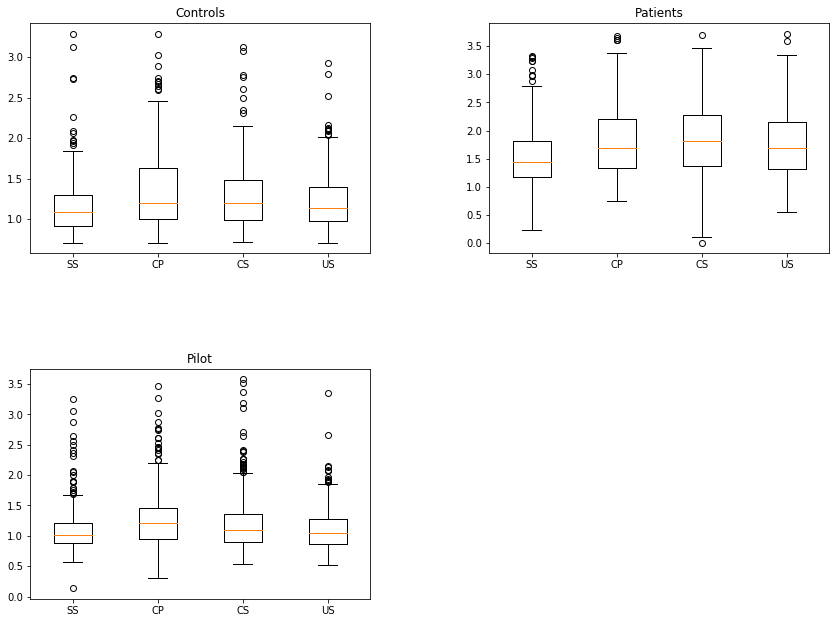

In [210]:
plt.figure(1)

plt.subplot(221)
plt.boxplot([controls_ss.rt.values, controls_cp.rt.values, controls_cs.rt.values, controls_us.rt.values], 
            labels=('SS', 'CP', 'CS', 'US'),)
plt.title('Controls')

plt.subplot(222)
plt.boxplot([patients_ss.rt.values, patients_cp.rt.values, patients_cs.rt.values, patients_us.rt.values], 
            labels=('SS', 'CP', 'CS', 'US'),)
plt.title('Patients')

plt.subplot(223)
plt.boxplot([pilot_ss.rt.values, pilot_cp.rt.values, pilot_cs.rt.values, pilot_us.rt.values], 
            labels=('SS', 'CP', 'CS', 'US'),)
plt.title('Pilot')

plt.subplots_adjust(top=2.0, bottom=0.001, left=0.10, right=1.95, hspace=0.50,
                    wspace=0.35)
plt.show()

### Accuracy

In [245]:
pilot_ss_accuracy = (len([x for x in pilot_ss.response.values if x >= 1]) / len(pilot_ss.response.values)) 
pilot_cp_accuracy = (len([x for x in pilot_cp.response.values if x >= 1]) / len(pilot_cp.response.values))
pilot_cs_accuracy = (len([x for x in pilot_cs.response.values if x >= 1]) / len(pilot_cs.response.values))
pilot_us_accuracy = (len([x for x in pilot_us.response.values if x >= 1]) / len(pilot_us.response.values))

controls_ss_accuracy = (len([x for x in controls_ss.response.values if x >= 1]) / len(controls_ss.response.values))
controls_cp_accuracy = (len([x for x in controls_cp.response.values if x >= 1]) / len(controls_cp.response.values))
controls_cs_accuracy = (len([x for x in controls_cs.response.values if x >= 1]) / len(controls_cs.response.values))
controls_us_accuracy = (len([x for x in controls_us.response.values if x >= 1]) / len(controls_us.response.values))

patients_ss_accuracy = (len([x for x in patients_ss.response.values if x >= 1]) / len(patients_ss.response.values)) 
patients_cp_accuracy = (len([x for x in patients_cp.response.values if x >= 1]) / len(patients_cp.response.values))
patients_cs_accuracy = (len([x for x in patients_cs.response.values if x >= 1]) / len(patients_cs.response.values))
patients_us_accuracy = (len([x for x in patients_us.response.values if x >= 1]) / len(patients_us.response.values))

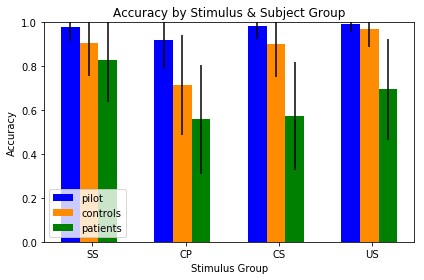

In [278]:
N = 4
ind = np.arange(N)
width = 0.20

fig, ax = plt.subplots()

pilot_accuracies = (pilot_ss_accuracy, pilot_cp_accuracy, pilot_cs_accuracy, pilot_us_accuracy)
pilot_response_stds = (pilot_ss.response.std() / 2, 
                       pilot_cp.response.std() / 2, 
                       pilot_cs.response.std() / 2, 
                       pilot_us.response.std() / 2)
pilot_axes = ax.bar(ind - width, pilot_accuracies, width, color='b', yerr=pilot_response_stds, label='pilot')

controls_accuracies = (controls_ss_accuracy, controls_cp_accuracy, controls_cs_accuracy, controls_us_accuracy)
controls_response_stds = (controls_ss.response.std() / 2, 
                          controls_cp.response.std() / 2, 
                          controls_cs.response.std() / 2, 
                          controls_us.response.std() / 2)
controls_axes = ax.bar(ind, controls_accuracies, width, color='darkorange', yerr=controls_response_stds, label='controls')

patients_accuracies = (patients_ss_accuracy, patients_cp_accuracy, patients_cs_accuracy, patients_us_accuracy)
patients_response_stds = (patients_ss.response.std() / 2, 
                          patients_cp.response.std() / 2, 
                          patients_cs.response.std() / 2, 
                          patients_us.response.std() / 2)
patients_axes = ax.bar(ind + width, patients_accuracies, width, color='g', yerr=patients_response_stds, label='patients')

ax.set_ylim([0.0, 1.0])
plt.xlabel('Stimulus Group')
plt.ylabel('Accuracy')
plt.title('Accuracy by Stimulus & Subject Group')
plt.xticks(ind + width / 6, ('SS', 'CP', 'CS', 'US'))
plt.legend(loc=3)

plt.tight_layout()
plt.show()

### Signal Detection Theory & d'

**Hit:** SS + "same" response  
**False Alarm:** US/CS/CP + "same" response

**Miss:** SS + "diff" response  
**Correct Rejection:** US/CS/CP + "diff" response

**Stim Group 1**: SS  
**Stim Group 2**: US + CS + CP

In [302]:
pilot_hits = len([x for x in pilot_ss.response.values if x >= 1])
pilot_fa = \
(len([x for x in pilot_cp.response.values if x == 0])) + \
(len([x for x in pilot_cs.response.values if x == 0])) + \
(len([x for x in pilot_us.response.values if x == 0]))

pilot_nstim1 = len(pilot_ss.response.values)
pilot_nstim2 = len(pilot_us.response.values) + len(pilot_cs.response.values) + len(pilot_cp.response.values)

signal_detection.signal_detection(n_stim1=pilot_nstim1, n_stim2=pilot_nstim2, hits=pilot_hits, false_alarms=pilot_fa)


{'beta': 0.6167773834959817,
 'c': -0.12353645660921353,
 'c_prime': -0.031580645441113171,
 'correct_rejections': 1387,
 'd_prime': 3.9117774473471636,
 'misses': 9,
 'z_false': -1.8323522670643684,
 'z_hits': 2.0794251802827954}

In [303]:
controls_hits = len([x for x in controls_ss.response.values if x >= 1])
controls_fa = \
(len([x for x in controls_cp.response.values if x == 0])) + \
(len([x for x in controls_cs.response.values if x == 0])) + \
(len([x for x in controls_us.response.values if x == 0]))

controls_nstim1 = len(controls_ss.response.values)
controls_nstim2 = len(controls_us.response.values) + len(controls_cs.response.values) + len(controls_cp.response.values)

signal_detection.signal_detection(n_stim1=controls_nstim1, n_stim2=controls_nstim2, hits=controls_hits, false_alarms=controls_fa)

{'beta': 0.7753316708452079,
 'c': -0.10618280081448583,
 'c_prime': -0.044307919411282919,
 'correct_rejections': 452,
 'd_prime': 2.3964745405636583,
 'misses': 17,
 'z_false': -1.0920544694673433,
 'z_hits': 1.304420071096315}

In [304]:
patients_hits = len([x for x in patients_ss.response.values if x >= 1])
patients_fa = \
(len([x for x in patients_cp.response.values if x == 0])) + \
(len([x for x in patients_cs.response.values if x == 0])) + \
(len([x for x in patients_us.response.values if x == 0]))

patients_nstim1 = len(patients_ss.response.values)
patients_nstim2 = len(patients_us.response.values) + len(patients_cs.response.values) + len(patients_cp.response.values)

signal_detection.signal_detection(n_stim1=patients_nstim1, n_stim2=patients_nstim2, hits=patients_hits, false_alarms=patients_fa)

{'beta': 0.6662475173785642,
 'c': -0.33381661883509334,
 'c_prime': -0.27440328308589385,
 'correct_rejections': 419,
 'd_prime': 1.216518312321365,
 'misses': 45,
 'z_false': -0.2744425373255891,
 'z_hits': 0.94207577499577577}

## Diffusion Decision Model Comparisons

### Drift Rate Between Stimuli Groups (Within Subjects)

Drift Rate Analysis: Pilot
P(v[SS] > v[US]) = 0.760795454545
P(v[SS] > v[CP]) = 1.0
P(v[SS] > v[CS]) = 0.998181818182
P(v[CP] > v[CS]) = 0.0
P(v[CP] > v[US]) = 0.0
P(v[CS] > v[US]) = 0.0110227272727


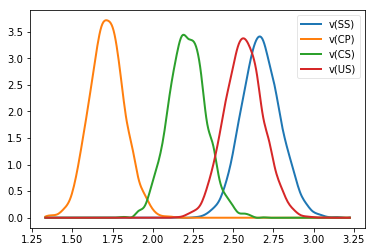

In [186]:
pilot_vSS, pilot_vCP, pilot_vCS, pilot_vUS = pilot_model.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([pilot_vSS, pilot_vCP, pilot_vCS, pilot_vUS])

print("Drift Rate Analysis: Pilot")
print('P(v[SS] > v[US]) = ' + str((pilot_vSS.trace() > pilot_vUS.trace()).mean()))
print('P(v[SS] > v[CP]) = ' + str((pilot_vSS.trace() > pilot_vCP.trace()).mean()))
print('P(v[SS] > v[CS]) = ' + str((pilot_vSS.trace() > pilot_vCS.trace()).mean()))
print('P(v[CP] > v[CS]) = ' + str((pilot_vCP.trace() > pilot_vCS.trace()).mean()))
print('P(v[CP] > v[US]) = ' + str((pilot_vCP.trace() > pilot_vUS.trace()).mean()))
print('P(v[CS] > v[US]) = ' + str((pilot_vCS.trace() > pilot_vUS.trace()).mean()))

Drift Rate Analysis: Controls
P(v[SS] > v[US]) = 0.315
P(v[SS] > v[CP]) = 0.989431818182
P(v[SS] > v[CS]) = 0.800909090909
P(v[CP] > v[CS]) = 0.06125
P(v[CP] > v[US]) = 0.00511363636364
P(v[CS] > v[US]) = 0.0948863636364


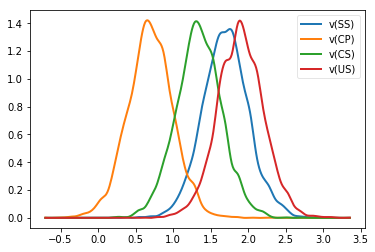

In [123]:
controls_vSS, controls_vCP, controls_vCS, controls_vUS = controls_model.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([controls_vSS, controls_vCP, controls_vCS, controls_vUS])

print("Drift Rate Analysis: Controls")
print('P(v[SS] > v[US]) = ' + str((controls_vSS.trace() > controls_vUS.trace()).mean()))
print('P(v[SS] > v[CP]) = ' + str((controls_vSS.trace() > controls_vCP.trace()).mean()))
print('P(v[SS] > v[CS]) = ' + str((controls_vSS.trace() > controls_vCS.trace()).mean()))
print('P(v[CP] > v[CS]) = ' + str((controls_vCP.trace() > controls_vCS.trace()).mean()))
print('P(v[CP] > v[US]) = ' + str((controls_vCP.trace() > controls_vUS.trace()).mean()))
print('P(v[CS] > v[US]) = ' + str((controls_vCS.trace() > controls_vUS.trace()).mean()))

Drift Rate Analysis: Patients
P(v[SS] > v[US]) = 0.922045454545
P(v[SS] > v[CP]) = 0.983068181818
P(v[SS] > v[CS]) = 0.984659090909
P(v[CP] > v[CS]) = 0.486136363636
P(v[CP] > v[US]) = 0.205227272727
P(v[CS] > v[US]) = 0.209318181818


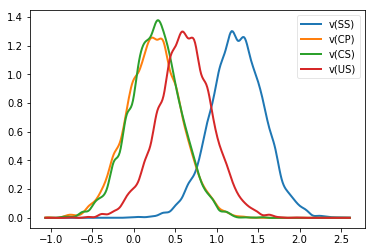

In [124]:
patients_vSS, patients_vCP, patients_vCS, patients_vUS = patients_model.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([patients_vSS, patients_vCP, patients_vCS, patients_vUS])

print("Drift Rate Analysis: Patients")
print('P(v[SS] > v[US]) = ' + str((patients_vSS.trace() > patients_vUS.trace()).mean()))
print('P(v[SS] > v[CP]) = ' + str((patients_vSS.trace() > patients_vCP.trace()).mean()))
print('P(v[SS] > v[CS]) = ' + str((patients_vSS.trace() > patients_vCS.trace()).mean()))
print('P(v[CP] > v[CS]) = ' + str((patients_vCP.trace() > patients_vCS.trace()).mean()))
print('P(v[CP] > v[US]) = ' + str((patients_vCP.trace() > patients_vUS.trace()).mean()))
print('P(v[CS] > v[US]) = ' + str((patients_vCS.trace() > patients_vUS.trace()).mean()))

---

---

### Drift Rate Between Subjects & Stimuli Groups

Drift Rate Analysis: SS
P(patients_vSS > controls_vSS) = 0.145227272727
P(controls_vSS > pilot_vSS) = 0.00181818181818


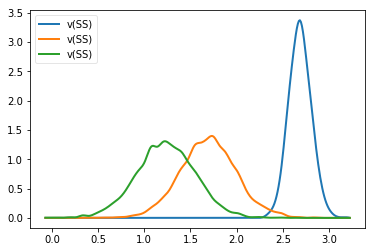

In [190]:
pilot_vSS = pilot_model.nodes_db.node['v(SS)']
controls_vSS = controls_model.nodes_db.node['v(SS)']
patients_vSS = patients_model.nodes_db.node['v(SS)']

hddm.analyze.plot_posterior_nodes([pilot_vSS, controls_vSS, patients_vSS])

print("Drift Rate Analysis: SS")
print('P(patients_vSS > controls_vSS) = ' + str((patients_vSS.trace() > controls_vSS.trace()).mean()))
print('P(controls_vSS > pilot_vSS) = ' + str((controls_vSS.trace() > pilot_vSS.trace()).mean()))

Drift Rate Analysis: US
P(patients_vUS > controls_vUS) = 0.00340909090909
P(controls_vUS > pilot_vUS) = 0.0201136363636


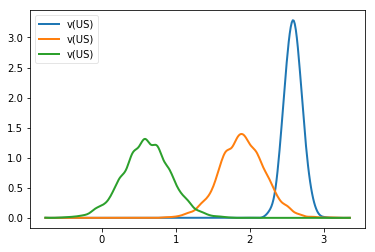

In [191]:
pilot_vUS = pilot_model.nodes_db.node['v(US)']
controls_vUS = controls_model.nodes_db.node['v(US)']
patients_vUS = patients_model.nodes_db.node['v(US)']

hddm.analyze.plot_posterior_nodes([pilot_vUS, controls_vUS, patients_vUS])

print("Drift Rate Analysis: US")
print('P(patients_vUS > controls_vUS) = ' + str((patients_vUS.trace() > controls_vUS.trace()).mean()))
print('P(controls_vUS > pilot_vUS) = ' + str((controls_vUS.trace() > pilot_vUS.trace()).mean()))

Drift Rate Analysis: CS
P(patients_vCS > controls_vCS) = 0.00670454545455
P(controls_vCS > pilot_vCS) = 0.00352272727273


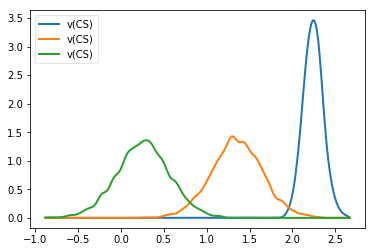

In [192]:
pilot_vCS = pilot_model.nodes_db.node['v(CS)']
controls_vCS = controls_model.nodes_db.node['v(CS)']
patients_vCS = patients_model.nodes_db.node['v(CS)']

hddm.analyze.plot_posterior_nodes([pilot_vCS, controls_vCS, patients_vCS])

print("Drift Rate Analysis: CS")
print('P(patients_vCS > controls_vCS) = ' + str((patients_vCS.trace() > controls_vCS.trace()).mean()))
print('P(controls_vCS > pilot_vCS) = ' + str((controls_vCS.trace() > pilot_vCS.trace()).mean()))

Drift Rate Analysis: CP
P(patients_vCP > controls_vCP) = 0.147954545455
P(controls_vCP > pilot_vCP) = 0.00181818181818


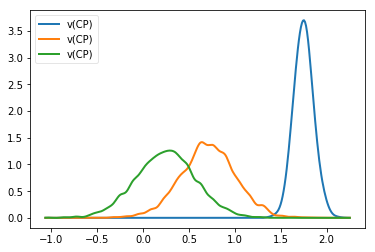

In [193]:
pilot_vCP = pilot_model.nodes_db.node['v(CP)']
controls_vCP = controls_model.nodes_db.node['v(CP)']
patients_vCP = patients_model.nodes_db.node['v(CP)']

hddm.analyze.plot_posterior_nodes([pilot_vCP, controls_vCP, patients_vCP])

print("Drift Rate Analysis: CP")
print('P(patients_vCP > controls_vCP) = ' + str((patients_vCP.trace() > controls_vCP.trace()).mean()))
print('P(controls_vCP > pilot_vCP) = ' + str((controls_vCP.trace() > pilot_vCP.trace()).mean()))

---

---

### Non-Decision Time Between Subjects

Non-Decision Time Analysis
P(patients_t > controls_t) = 0.126704545455
P(controls_t > pilot_t) = 0.909886363636


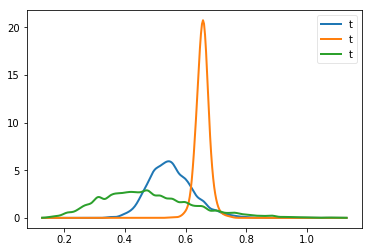

In [194]:
pilot_t = pilot_model.nodes_db.node['t']
controls_t = controls_model.nodes_db.node['t']
patients_t = patients_model.nodes_db.node['t']

hddm.analyze.plot_posterior_nodes([pilot_t, controls_t, patients_t])

print("Non-Decision Time Analysis")
print('P(patients_t > controls_t) = ' + str((patients_t.trace() > controls_t.trace()).mean()))
print('P(controls_t > pilot_t) = ' + str((controls_t.trace() > pilot_t.trace()).mean()))

---

---

### Bias Between Subjects

Bias Analysis
P(patients_z > controls_z) = 0.000227272727273
P(controls_z > pilot_z) = 0.996590909091


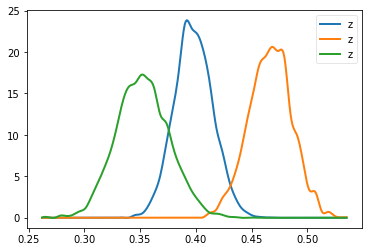

In [195]:
pilot_z = pilot_model.nodes_db.node['z']
controls_z = controls_model.nodes_db.node['z']
patients_z = patients_model.nodes_db.node['z']

hddm.analyze.plot_posterior_nodes([pilot_z, controls_z, patients_z])

print("Bias Analysis")
print('P(patients_z > controls_z) = ' + str((patients_z.trace() > controls_z.trace()).mean()))
print('P(controls_z > pilot_z) = ' + str((controls_z.trace() > pilot_z.trace()).mean()))

---  


---

### Threshold

#### Between Subjects

Tested from model where stimulus type does not affect threshold

Threshold Analysis: Between-Subjects
P(patients_a > controls_a) = 0.998522727273
P(controls_a > pilot_a) = 0.0260227272727


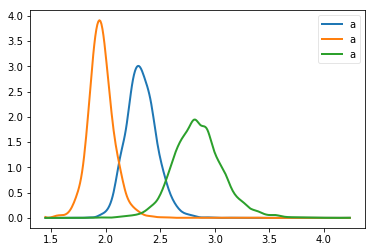

In [196]:
pilot_a = pilot_model.nodes_db.node['a']
controls_a = controls_model.nodes_db.node['a']
patients_a = patients_model.nodes_db.node['a']

hddm.analyze.plot_posterior_nodes([pilot_a, controls_a, patients_a])

print("Threshold Analysis: Between-Subjects")
print('P(patients_a > controls_a) = ' + str((patients_a.trace() > controls_a.trace()).mean()))
print('P(controls_a > pilot_a) = ' + str((controls_a.trace() > pilot_a.trace()).mean()))

---

#### Between Subjects & Stimuli Groups (threshold affected by stimulus type)

Threshold Analysis: SS
P(patients_aSS > controls_aSS) = 0.995306122449
P(controls_aSS > pilot_aSS) = 0.00163265306122


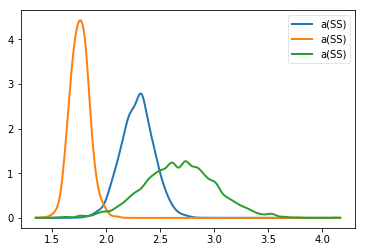

In [201]:
pilot_aSS = pilot_model_threshold.nodes_db.node['a(SS)']
controls_aSS = controls_model_threshold.nodes_db.node['a(SS)']
patients_aSS = patients_model_threshold.nodes_db.node['a(SS)']

hddm.analyze.plot_posterior_nodes([pilot_aSS, controls_aSS, patients_aSS])

print("Threshold Analysis: SS")
print('P(patients_aSS > controls_aSS) = ' + str((patients_aSS.trace() > controls_aSS.trace()).mean()))
print('P(controls_aSS > pilot_aSS) = ' + str((controls_aSS.trace() > pilot_aSS.trace()).mean()))

Threshold Analysis: US
P(patients_aUS > controls_aUS) = 0.998775510204
P(controls_aUS > pilot_aUS) = 0.117959183673


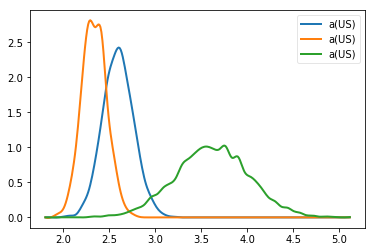

In [202]:
pilot_aUS = pilot_model_threshold.nodes_db.node['a(US)']
controls_aUS = controls_model_threshold.nodes_db.node['a(US)']
patients_aUS = patients_model_threshold.nodes_db.node['a(US)']

hddm.analyze.plot_posterior_nodes([pilot_aUS, controls_aUS, patients_aUS])

print("Threshold Analysis: US")
print('P(patients_aUS > controls_aUS) = ' + str((patients_aUS.trace() > controls_aUS.trace()).mean()))
print('P(controls_aUS > pilot_aUS) = ' + str((controls_aUS.trace() > pilot_aUS.trace()).mean()))

Threshold Analysis: CS
P(patients_aCS > controls_aCS) = 0.965510204082
P(controls_aCS > pilot_aCS) = 0.00540816326531


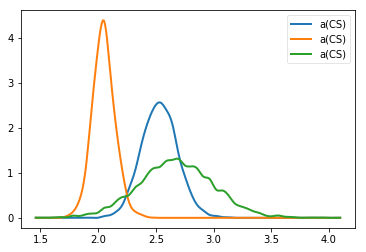

In [203]:
pilot_aCS = pilot_model_threshold.nodes_db.node['a(CS)']
controls_aCS = controls_model_threshold.nodes_db.node['a(CS)']
patients_aCS = patients_model_threshold.nodes_db.node['a(CS)']

hddm.analyze.plot_posterior_nodes([pilot_aCS, controls_aCS, patients_aCS])

print("Threshold Analysis: CS")
print('P(patients_aCS > controls_aCS) = ' + str((patients_aCS.trace() > controls_aCS.trace()).mean()))
print('P(controls_aCS > pilot_aCS) = ' + str((controls_aCS.trace() > pilot_aCS.trace()).mean()))

Threshold Analysis: CP
P(patients_aCP > controls_aCP) = 0.997040816327
P(controls_aCP > pilot_aCP) = 0.00540816326531


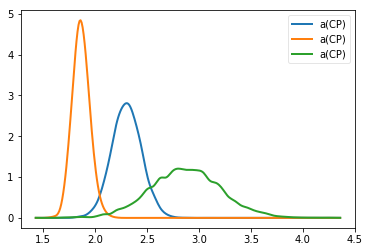

In [204]:
pilot_aCP = pilot_model_threshold.nodes_db.node['a(CP)']
controls_aCP = controls_model_threshold.nodes_db.node['a(CP)']
patients_aCP = patients_model_threshold.nodes_db.node['a(CP)']

hddm.analyze.plot_posterior_nodes([pilot_aCP, controls_aCP, patients_aCP])

print("Threshold Analysis: CP")
print('P(patients_aCP > controls_aCP) = ' + str((patients_aCP.trace() > controls_aCP.trace()).mean()))
print('P(controls_aCP > pilot_aCP) = ' + str((controls_aCP.trace() > pilot_aCP.trace()).mean()))

---

#### Within Subjects / Between Stimuli Groups

Threshold Analysis: Pilot
P(a[SS] > a[US]) = 0.0634693877551
P(a[SS] > a[CP]) = 0.476224489796
P(a[SS] > a[CS]) = 0.128571428571
P(a[CP] > a[CS]) = 0.128979591837
P(a[CP] > a[US]) = 0.075612244898
P(a[CS] > a[US]) = 0.355816326531


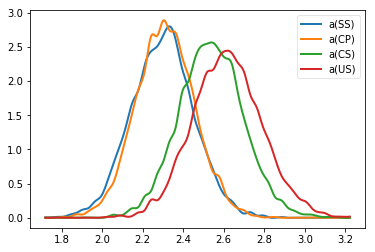

In [205]:
pilot_aSS, pilot_aCP, pilot_aCS, pilot_aUS = pilot_model_threshold.nodes_db.node[['a(SS)', 'a(CP)', 'a(CS)', 'a(US)']]

hddm.analyze.plot_posterior_nodes([pilot_aSS, pilot_aCP, pilot_aCS, pilot_aUS])

print("Threshold Analysis: Pilot")
print('P(a[SS] > a[US]) = ' + str((pilot_aSS.trace() > pilot_aUS.trace()).mean()))
print('P(a[SS] > a[CP]) = ' + str((pilot_aSS.trace() > pilot_aCP.trace()).mean()))
print('P(a[SS] > a[CS]) = ' + str((pilot_aSS.trace() > pilot_aCS.trace()).mean()))
print('P(a[CP] > a[CS]) = ' + str((pilot_aCP.trace() > pilot_aCS.trace()).mean()))
print('P(a[CP] > a[US]) = ' + str((pilot_aCP.trace() > pilot_aUS.trace()).mean()))
print('P(a[CS] > a[US]) = ' + str((pilot_aCS.trace() > pilot_aUS.trace()).mean()))

Threshold Analysis: Controls
P(a[SS] > a[US]) = 0.0
P(a[SS] > a[CP]) = 0.166632653061
P(a[SS] > a[CS]) = 0.0158163265306
P(a[CP] > a[CS]) = 0.0722448979592
P(a[CP] > a[US]) = 0.000612244897959
P(a[CS] > a[US]) = 0.0238775510204


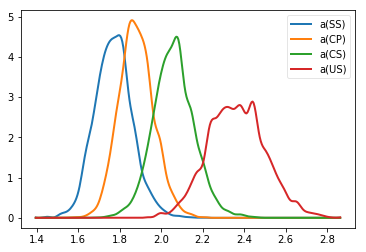

In [120]:
controls_aSS, controls_aCP, controls_aCS, controls_aUS = controls_model_threshold.nodes_db.node[['a(SS)', 'a(CP)', 'a(CS)', 'a(US)']]

hddm.analyze.plot_posterior_nodes([controls_aSS, controls_aCP, controls_aCS, controls_aUS])

print("Threshold Analysis: Controls")
print('P(a[SS] > a[US]) = ' + str((controls_aSS.trace() > controls_aUS.trace()).mean()))
print('P(a[SS] > a[CP]) = ' + str((controls_aSS.trace() > controls_aCP.trace()).mean()))
print('P(a[SS] > a[CS]) = ' + str((controls_aSS.trace() > controls_aCS.trace()).mean()))
print('P(a[CP] > a[CS]) = ' + str((controls_aCP.trace() > controls_aCS.trace()).mean()))
print('P(a[CP] > a[US]) = ' + str((controls_aCP.trace() > controls_aUS.trace()).mean()))
print('P(a[CS] > a[US]) = ' + str((controls_aCS.trace() > controls_aUS.trace()).mean()))

Threshold Analysis: Patients
P(a[SS] > a[US]) = 0.0348979591837
P(a[SS] > a[CP]) = 0.333367346939
P(a[SS] > a[CS]) = 0.507551020408
P(a[CP] > a[CS]) = 0.67
P(a[CP] > a[US]) = 0.0729591836735
P(a[CS] > a[US]) = 0.0322448979592


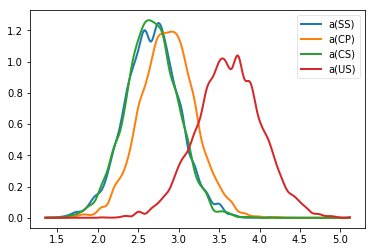

In [119]:
patients_aSS, patients_aCP, patients_aCS, patients_aUS = patients_model_threshold.nodes_db.node[['a(SS)', 'a(CP)', 'a(CS)', 'a(US)']]

hddm.analyze.plot_posterior_nodes([patients_aSS, patients_aCP, patients_aCS, patients_aUS])

print("Threshold Analysis: Patients")
print('P(a[SS] > a[US]) = ' + str((patients_aSS.trace() > patients_aUS.trace()).mean()))
print('P(a[SS] > a[CP]) = ' + str((patients_aSS.trace() > patients_aCP.trace()).mean()))
print('P(a[SS] > a[CS]) = ' + str((patients_aSS.trace() > patients_aCS.trace()).mean()))
print('P(a[CP] > a[CS]) = ' + str((patients_aCP.trace() > patients_aCS.trace()).mean()))
print('P(a[CP] > a[US]) = ' + str((patients_aCP.trace() > patients_aUS.trace()).mean()))
print('P(a[CS] > a[US]) = ' + str((patients_aCS.trace() > patients_aUS.trace()).mean()))

### Model Deviance Information Criterion (DIC)

Measure of model fitness for hierarchical models, lower is better

In [206]:
# Pilot models
print("Stimulus Model DIC: " + str(pilot_model.dic))
print("Stimulus+Threshold Model DIC: " + str(pilot_model_threshold.dic))

Stimulus Model DIC: 795.609087068
Stimulus+Threshold Model DIC: 837.340214268


In [139]:
# Control models
print("Stimulus Model DIC: " + str(controls_model.dic))
print("Stimulus+Threshold Model DIC: " + str(controls_model_threshold.dic))

Stimulus Model DIC: 800.516022989
Stimulus+Threshold Model DIC: 787.831113747


In [140]:
# Patient models
print("Stimulus Model DIC: " + str(patients_model.dic))
print("Stimulus+Threshold Model DIC: " + str(patients_model_threshold.dic))

Stimulus Model DIC: 2619.7750154
Stimulus+Threshold Model DIC: 2699.7418347
